<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/Lab_4_WoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weight of Evidence Transformation

In this lab we will apply a Weight of Evidence transformation to our data. The idea is to:

- Split the data into a train/test set.
- Generate a relevant set of cuts to our data.
- Calculate the WoE for each variable.
- Save the data we just created.

We are assuming we have already cleaned the date of outliers and null values.

In order to do this we will use the fantastic  [```scorecardpy```](https://github.com/ShichenXie/scorecardpy) Python package. First we need to install it, as it is not a standard package.

We use the OS python software ```pip``` for this.

In [1]:
pip install scorecardpy

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-cp37-none-any.whl size=57826 sha256=356b0261a080e45a1a0d57ba34b1aa0cdd5fc7832ffbd0006e78b7fe8c264f6b
  Stored in directory: /root/.cache/pip/wheels/1d/66/14/23aeb4e1128278f5880580e2fdd10e956de112a5d56a3a043e
Successfully built scorecardpy


Now we import the data to use. I have summarized the commands from the last lab into the following block:

In [2]:
!wget --no-check-certificate --output-document=Bankloan.csv 'https://docs.google.com/spreadsheets/d/1Am74y2ZVQ6dRFYVZUv_VoyP-OTS8BM4x0svifHQvtNc/export?gid=819627738&format=csv'

import pandas as pd

bankloan_data = pd.read_csv('Bankloan.csv')

bankloan_data = bankloan_data.loc[(bankloan_data['Income'] < 300) &
                                  (bankloan_data['Creddebt'] < 15) & 
                                  (bankloan_data['OthDebt'] < 30)]

bankloan_data.describe()

--2021-02-25 13:09:09--  https://docs.google.com/spreadsheets/d/1Am74y2ZVQ6dRFYVZUv_VoyP-OTS8BM4x0svifHQvtNc/export?gid=819627738&format=csv
Resolving docs.google.com (docs.google.com)... 173.194.214.138, 173.194.214.113, 173.194.214.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.214.138|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0k-8s-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/2anj9qhf89d0j486c2lrm8hms4/1614258550000/102123285539774178265/*/1Am74y2ZVQ6dRFYVZUv_VoyP-OTS8BM4x0svifHQvtNc?gid=819627738&format=csv [following]
--2021-02-25 13:09:10--  https://doc-0k-8s-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/2anj9qhf89d0j486c2lrm8hms4/1614258550000/102123285539774178265/*/1Am74y2ZVQ6dRFYVZUv_VoyP-OTS8BM4x0svifHQvtNc?gid=819627738&format=csv
Resolving doc-0k-8s-sheets.googleusercontent.com (doc-0k-8s-sheets.googleusercontent.com)... 173.194.211.132, 2607:f8b0:400c:c10::84

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000
mean,257292.708731,33.654843,6.450205,6.075034,52.535471,9.862619,1.674829,3.388247,0.369714,0.363574
std,139836.339003,12.717335,8.213568,5.848704,40.800912,6.586403,2.005911,3.663486,0.295177,0.481192
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98156.750000,24.000000,0.000000,2.000000,27.000000,4.800000,0.410000,1.080000,0.152500,0.000000
50%,316020.000000,30.500000,3.000000,4.000000,39.000000,8.500000,0.945000,2.170000,0.300000,0.000000
75%,370670.750000,41.000000,9.000000,9.000000,62.000000,13.400000,2.097500,4.397500,0.500000,1.000000
max,453777.000000,77.000000,51.000000,34.000000,289.000000,40.700000,14.370000,28.940000,2.150000,1.000000


In [4]:
!head Bankloan.csv

customer,Age,Education,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
10012,28,Med,7,2,44,17.7,2.99,4.8,0.58,0
10017,64,Posg,34,17,116,14.7,05.05,12,0.27,0
10030,40,Bas,20,12,61,4.8,01.04,1.89,0.13,0
10039,30,Bas,11,3,27,34.5,1.75,7.56,1.62,0
10069,25,Bas,2,2,30,22.4,0.76,5.96,0.97,1
10071,35,Bas,2,9,38,10.9,1.46,2.68,0.40,1
10096,26,1upInc,2,4,38,11.9,0.95,3.57,0.43,1
10128,25,Bas,4,2,30,14.4,01.05,3.27,0.62,0
10129,65,1upCom,29,14,189,5,3.36,06.09,0.08,0


## Binning

The first step is to properly bin the data. Usually, we will run a tree and manually adjust those cases that do not follow a logical pattern.

However, as calculating WoE means we need to use the objective variable, we need to first create a train and test split. The scorecard package comes with a function to do so easily,  ```split_df```, which takes as an argument the ratio and the seed.

**Note: A random seed is used to generate a random split that will be reproducible (is there such as thing as randomness in a computer?). I expect for all coursework for you to use your student ID.**

In [5]:
import scorecardpy as sc
import numpy as np

In [6]:
# Split in train and test BEFORE we apply WoE
# Use your Student ID as seed!

train, test = sc.split_df(bankloan_data.iloc[:,1:],
                          y = 'Default',
                          ratio = 0.7, seed = 20190227).values()

In [7]:
train.describe()

,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,33.880117,6.573099,6.116959,52.544834,9.911988,1.693226,3.474912,0.370409,0.363548
std,12.767117,8.433442,5.851659,41.475193,6.484323,2.029981,3.887779,0.287490,0.481255
min,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,27.000000,4.900000,0.400000,1.052500,0.160000,0.000000
50%,31.000000,3.000000,5.000000,38.500000,8.650000,0.940000,2.170000,0.295000,0.000000
75%,41.000000,9.000000,9.000000,61.000000,13.700000,2.020000,4.477500,0.500000,1.000000
max,77.000000,51.000000,34.000000,289.000000,36.800000,13.410000,28.940000,2.110000,1.000000


Now we can bin the variables. The function  ```woebin``` will do this automatically for us. It will use trees sequentially given the constraints we decide. It is good practice to not leave less than 5% of cases in each bin, and I am using 50 starting bins. It might be a bit less given the data is small (say, 20), but it is not terribly important at this stage. 

**Tip:  For larger datasets, use a relatively large number of bins (50 to 100), for smaller ones, use less.**

In [8]:
bins = sc.woebin(train, y = 'Default', 
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.1, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 method='tree')

[INFO] creating woe binning ...


Now we can plot the results. We need to be able to explain the results for each variable. We should be able to explain every trend. They do not need to necessarilly be linear, we just need a good explanation for the trend.

**If you cannot explain the trend you need to adjust the bins.** 

{'Address': <Figure size 432x288 with 2 Axes>,
 'Age': <Figure size 432x288 with 2 Axes>,
 'Creddebt': <Figure size 432x288 with 2 Axes>,
 'Education': <Figure size 432x288 with 2 Axes>,
 'Employ': <Figure size 432x288 with 2 Axes>,
 'Income': <Figure size 432x288 with 2 Axes>,
 'Leverage': <Figure size 432x288 with 2 Axes>,
 'MonthlyLoad': <Figure size 432x288 with 2 Axes>,
 'OthDebt': <Figure size 432x288 with 2 Axes>}

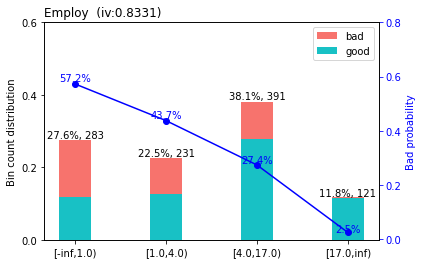

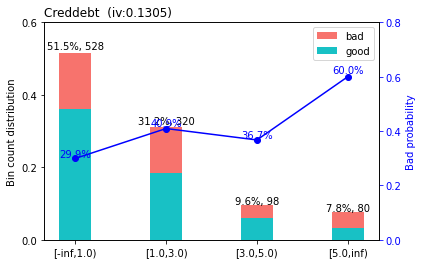

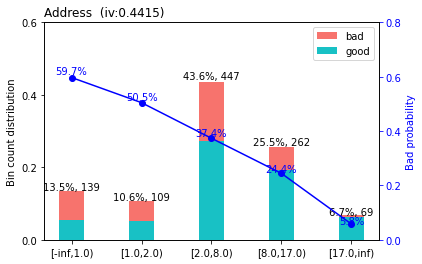

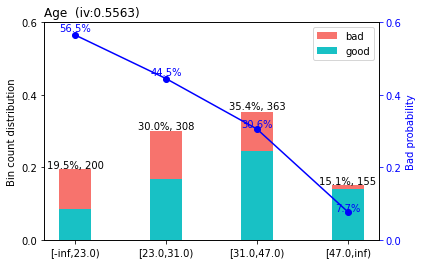

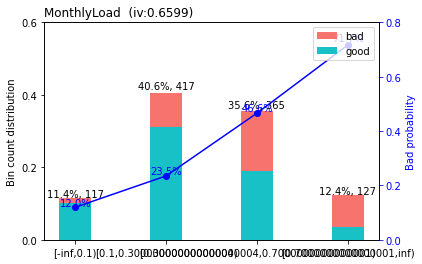

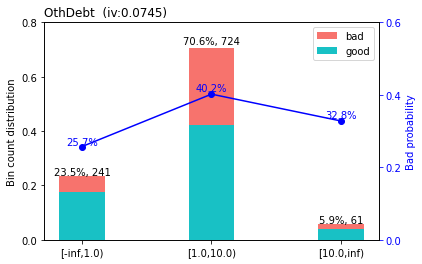

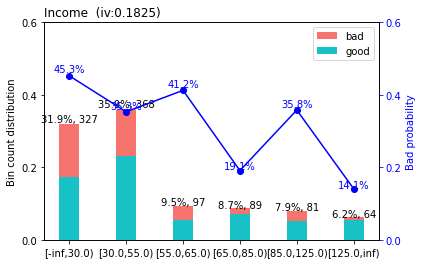

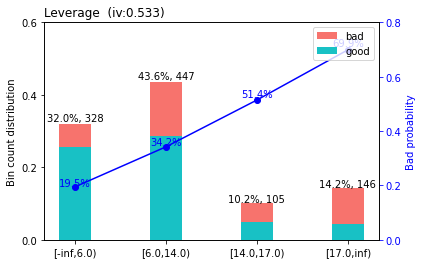

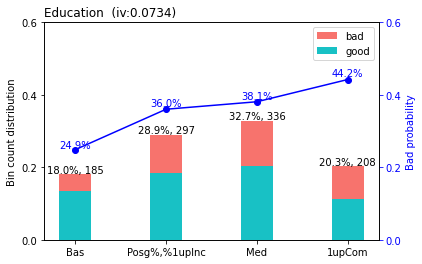

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sc.woebin_plot(bins)

## Manual adjustment

In this case, OthDebt and Income don't follow an explainable trend, so we need to make manual adjustments. We can make this interactively within the package  with the excelent function ```woebin_adj``` that allows us to make adjustments one by one. We start by invoking the function, note the bar at the end.

-------- 1/7 Address --------
>>> dt[Address].describe(): 
count    1026.000000
mean        6.116959
std         5.851659
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        34.000000
Name: Address, dtype: float64 



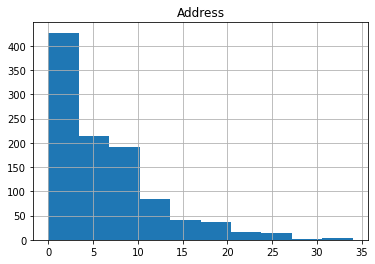

>>> Current breaks:
1.0,2.0,8.0,17.0 



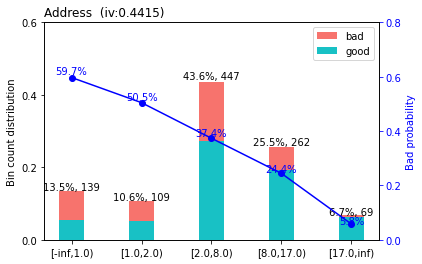

>>> Adjust breaks for (1/7) Address?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/7 Age --------
>>> dt[Age].describe(): 
count    1026.000000
mean       33.880117
std        12.767117
min        18.000000
25%        24.000000
50%        31.000000
75%        41.000000
max        77.000000
Name: Age, dtype: float64 



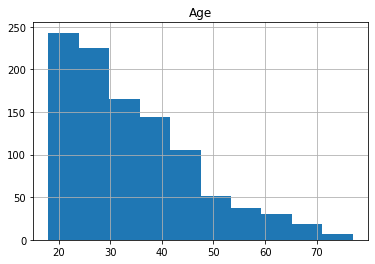

>>> Current breaks:
23.0,31.0,47.0 



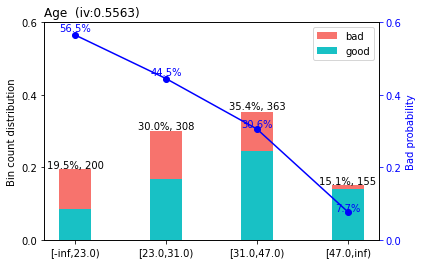

>>> Adjust breaks for (2/7) Age?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/7 Creddebt --------
>>> dt[Creddebt].describe(): 
count    1026.000000
mean        1.693226
std         2.029981
min         0.000000
25%         0.400000
50%         0.940000
75%         2.020000
max        13.410000
Name: Creddebt, dtype: float64 



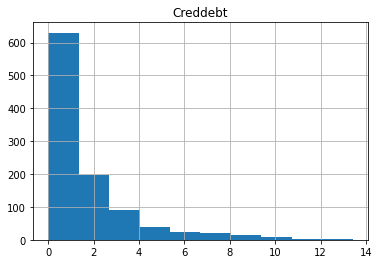

>>> Current breaks:
1.0,3.0,5.0 



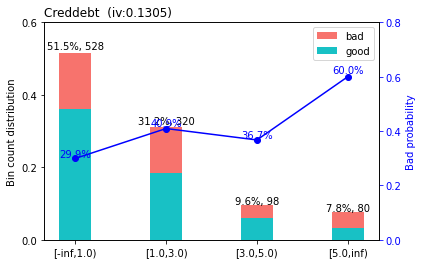

>>> Adjust breaks for (3/7) Creddebt?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 1,5
[INFO] creating woe binning ...
>>> Current breaks:
1.0, 5.0 



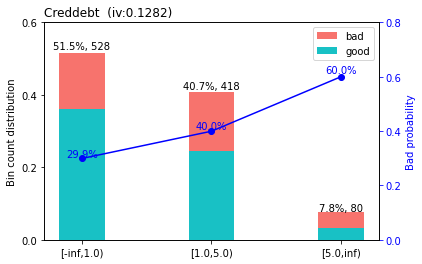

>>> Adjust breaks for (3/7) Creddebt?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/7 Education --------
>>> dt[Education].describe(): 
count     1026
unique       5
top        Med
freq       336
Name: Education, dtype: object 

>>> dt[Education].value_counts(): 
Med       336
1upInc    233
1upCom    208
Bas       185
Posg       64
Name: Education, dtype: int64 

>>> Current breaks:
'Bas','Posg%,%1upInc','Med','1upCom' 



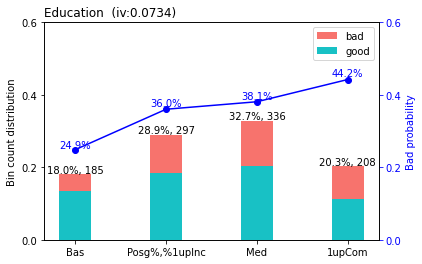

>>> Adjust breaks for (4/7) Education?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/7 Income --------
>>> dt[Income].describe(): 
count    1026.000000
mean       52.544834
std        41.475193
min        12.000000
25%        27.000000
50%        38.500000
75%        61.000000
max       289.000000
Name: Income, dtype: float64 



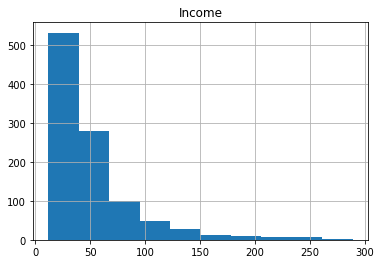

>>> Current breaks:
30.0,55.0,65.0,85.0,125.0 



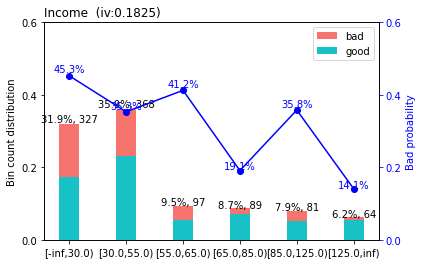

>>> Adjust breaks for (5/7) Income?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 30,65,125
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 125.0, 65.0 



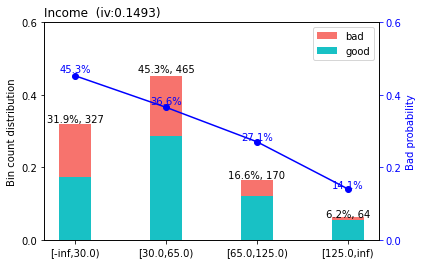

>>> Adjust breaks for (5/7) Income?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/7 Leverage --------
>>> dt[Leverage].describe(): 
count    1026.000000
mean        9.911988
std         6.484323
min         0.000000
25%         4.900000
50%         8.650000
75%        13.700000
max        36.800000
Name: Leverage, dtype: float64 



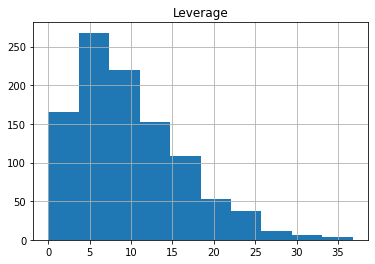

>>> Current breaks:
6.0,14.0,17.0 



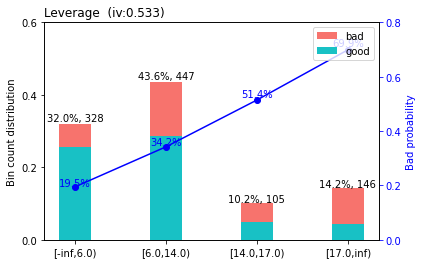

>>> Adjust breaks for (6/7) Leverage?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/7 MonthlyLoad --------
>>> dt[MonthlyLoad].describe(): 
count    1026.000000
mean        0.370409
std         0.287490
min         0.000000
25%         0.160000
50%         0.295000
75%         0.500000
max         2.110000
Name: MonthlyLoad, dtype: float64 



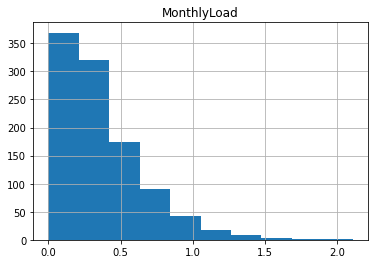

>>> Current breaks:
0.1,0.30000000000000004,0.7000000000000001 



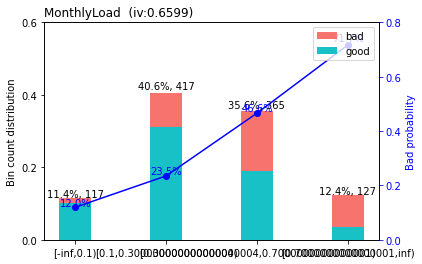

>>> Adjust breaks for (7/7) MonthlyLoad?
1: next 
2: yes 
3: back
Selection: 1


In [11]:
breaks_adj = sc.woebin_adj(train, "Default", bins)

In [ ]:
#no need to run this block if you have changed the bins before, see course video for detail#
breaks_adj = {
    # Below are the intervals for different bins
    'Income': [25.0,40.0,55.0,90.0],
    'OthDebt': [1.0,2.0,3.0,4.0],
}
bins_adj = sc.woebin(train, y="Default", breaks_list=breaks_adj)
sc.woebin_plot(bins_adj)
#no need to run this block if you have changed the bins before#

[INFO] creating woe binning ...


{'Address': <Figure size 432x288 with 2 Axes>,
 'Age': <Figure size 432x288 with 2 Axes>,
 'Creddebt': <Figure size 432x288 with 2 Axes>,
 'Education': <Figure size 432x288 with 2 Axes>,
 'Employ': <Figure size 432x288 with 2 Axes>,
 'Income': <Figure size 432x288 with 2 Axes>,
 'Leverage': <Figure size 432x288 with 2 Axes>,
 'MonthlyLoad': <Figure size 432x288 with 2 Axes>,
 'OthDebt': <Figure size 432x288 with 2 Axes>}

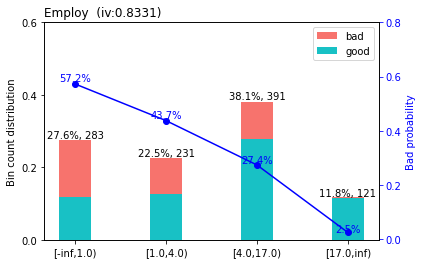

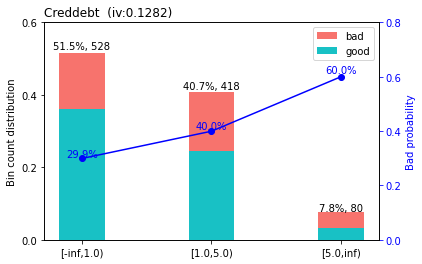

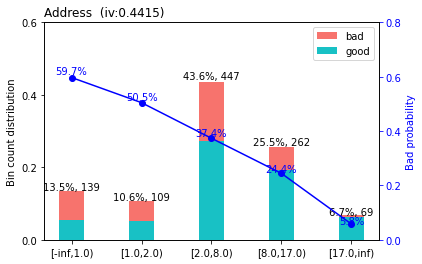

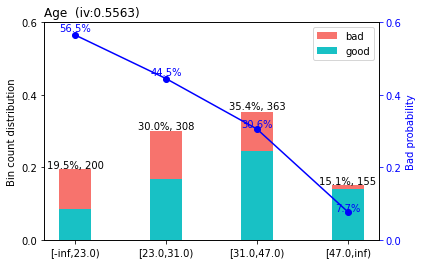

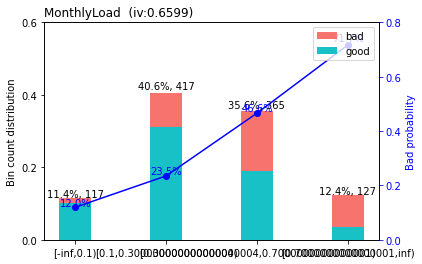

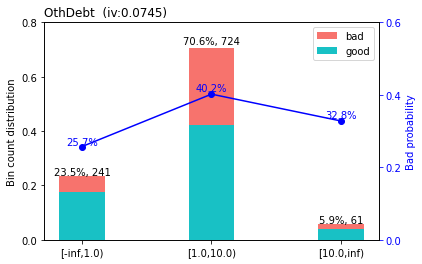

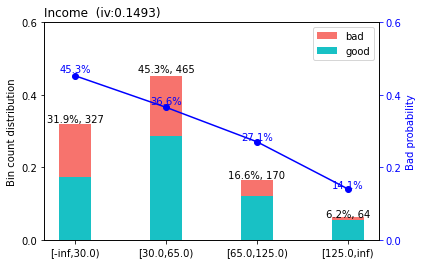

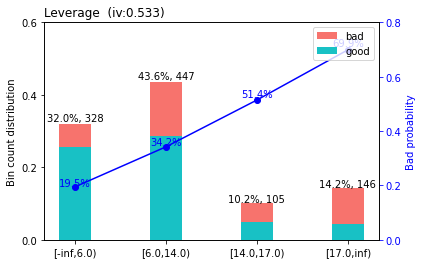

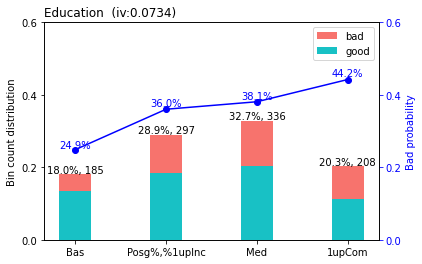

In [13]:
bins_adj = sc.woebin(train, y="Default", breaks_list=breaks_adj)
sc.woebin_plot(bins_adj)

We will only adjust Income. We enter the following breaks:

```25.0,40.0,55.0,90.0```

The variable is now much better behaved. Play around with the breaks to see if you can get to better solutions.  Income is a tricky variable: Its IV is 0.13 in the original (incorrect) binning, but the corrected one is below 0.1 so it would be discarded. We could play around a bit more to see if we can get it to be rational. OthDebt on the other hand  it is not worth it to do so, as the best possible binning has an IV below 0.1, so no matter what we do we would still eliminate the variable, so we leave it be.

Now that we are happy with the binnings, **we need to apply it to both of our datasets**.

In [34]:
train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [26]:
train_woe.head()

,Default,Employ_woe,Creddebt_woe,Address_woe,Age_woe,MonthlyLoad_woe,OthDebt_woe,Income_woe,Leverage_woe,Education_woe
0,0,-0.416147,0.152540,0.043203,0.338316,0.422798,0.162584,0.008822,1.400782,0.074491
1,0,-3.112074,0.965464,-2.228094,-1.917939,-0.620225,-0.157841,-0.431641,0.617157,-0.014197
3,0,-0.416147,0.152540,0.043203,0.338316,1.487339,0.162584,0.369825,1.400782,-0.545834
4,1,0.307585,-0.290909,0.043203,0.338316,1.487339,0.162584,0.008822,1.400782,-0.545834
5,1,0.307585,0.152540,-0.569385,-0.259900,0.422798,0.162584,0.008822,-0.093143,-0.545834


## IV Filtering

Now we can check the information value of our variables and remove those who are not predictive. We use the function ```iv```. In general:

- $IV < 0.02$: No predictive ability, remove.
- $0.02 \le IV < 0.1$: Small predictive ability, suggest to remove.
- $0.1 \le IV < 0.3$: Medium predictive ability, leave.
- $0.3 \le IV < 1$: Good predictive ability, leave.
- $1 \le IV $: Strong predictive ability. Suspicious variable. Study if error in calculation (i.e. WoE leaves a category with 100% goods or bads) or if variable is capturing future information.

In [27]:
sc.iv(train_woe, 'Default')

,variable,info_value
7,Employ_woe,0.833114
3,MonthlyLoad_woe,0.659907
4,Age_woe,0.556347
5,Leverage_woe,0.532990
8,Address_woe,0.441514
1,Income_woe,0.149262
0,Creddebt_woe,0.128199
6,OthDebt_woe,0.074457
2,Education_woe,0.073415


As we can see, Education, and OthDebt are not relevant. We can easily remove them manually.

In [30]:
# Check column order.
train_woe.columns


Index(['Default', 'Employ_woe', 'Creddebt_woe', 'Address_woe', 'Age_woe',
       'MonthlyLoad_woe', 'OthDebt_woe', 'Income_woe', 'Leverage_woe',
       'Education_woe'],
      dtype='object')

In [38]:
# Create range of accepted variables
train_woe_adj = train_woe.drop(['Education_woe','OthDebt_woe'],axis=1)
test_woe_adj = test_woe.drop(['Education_woe','OthDebt_woe'],axis=1)
train_woe_adj.head()

,Default,Employ_woe,Creddebt_woe,Address_woe,Age_woe,MonthlyLoad_woe,Income_woe,Leverage_woe
0,0,-0.416147,0.152540,0.043203,0.338316,0.422798,0.008822,1.400782
1,0,-3.112074,0.965464,-2.228094,-1.917939,-0.620225,-0.431641,0.617157
3,0,-0.416147,0.152540,0.043203,0.338316,1.487339,0.369825,1.400782
4,1,0.307585,-0.290909,0.043203,0.338316,1.487339,0.008822,1.400782
5,1,0.307585,0.152540,-0.569385,-0.259900,0.422798,0.008822,-0.093143


In [41]:
test_woe_adj.head()

,Default,Employ_woe,Creddebt_woe,Address_woe,Age_woe,MonthlyLoad_woe,Income_woe,Leverage_woe
2,0,-3.112074,0.152540,-0.569385,-0.259900,-0.620225,0.008822,-0.857067
9,0,0.851804,-0.290909,0.953488,0.821478,-0.620225,0.369825,-0.857067
19,0,-3.112074,0.152540,-2.228094,-1.917939,-0.620225,-1.250110,-0.093143
20,1,0.307585,0.152540,0.578348,0.821478,-0.620225,0.008822,-0.093143
21,0,-0.416147,-0.290909,0.043203,0.338316,0.422798,0.008822,-0.093143


## Saving the results.

Now we are ready to apply models! We have our train and test datasets ready. We can now save the csv into our local file system or our Google Drive. In the latter case, the process is a bit complicated, as it requires us to connect our accounts. The detailed instructions are [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c).

We will download the data to our own hard drive. First we need to save our data as csv, using the function [```to_csv```](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html).

In [42]:
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)
!ls # Linux commands to check what files are in the computer. - this is colab!!!

Bankloan.csv  sample_data  test_woe.csv  train_woe.csv


Now we can download these two files. Next lab we'll import them. We have the subpackage ```files``` provided by Google, with functions ```upload``` and ```download``` for this.

In [ ]:
from google.colab import files
files.download("train_woe.csv")

In [ ]:
files.download("test_woe.csv")